## Augmented synthetic control method 

In [202]:
import pandas as pd
import numpy as np
from pysyncon import Dataprep, Synth, AugSynth
import matplotlib.pyplot as plt
import seaborn as sns
import os
os.chdir('/Users/wang/Desktop/8. Literature Light Map/3. sythetic control')

### 1. The data
+ we use the data from the last chapter of the book "Causal Inference: The Mixtape" by Scott Cunningham that examined prison construction and black male incarceration in the state of Texas. The treatment is happend in Texas in 1993.

In [203]:
df = pd.read_stata("data/texas.dta")

# build the treatment indicator
df['treated'] = (df['state'] == 'Texas') & (df['year'] >= 1993)

In [204]:
df.query("state=='Texas' & year > 1990")[['state', 'year', 'bmprison', 'treated']].head()

,state,year,bmprison,treated
694,Texas,1991.0,23249.0,False
695,Texas,1992.0,27568.0,False
696,Texas,1993.0,29260.0,True
697,Texas,1994.0,40451.0,True
698,Texas,1995.0,55602.0,True


In [205]:
# prepare the control group
X = df.query("state!='Texas'").pivot(index='year', columns='state', values='bmprison')

# prepare the treatment group
y = df.query("state=='Texas'").pivot(index='year', columns='state', values='bmprison')

In [206]:
X.iloc[0:5, 0:5]

state,Alabama,Alaska,Arizona,Arkansas,California
year,,,,,
1985.0,6227.0,198.0,1297.0,2153.0,16138.0
1986.0,6657.0,211.0,1452.0,2238.0,19549.0
1987.0,7281.0,217.0,1675.0,2536.0,22184.0
1988.0,7244.0,271.0,1775.0,2646.0,26438.0
1989.0,8056.0,310.0,2033.0,3126.0,30066.0


In [207]:
y.head()

state,Texas
year,
1985.0,14828.0
1986.0,15207.0
1987.0,15780.0
1988.0,16956.0
1989.0,19366.0


### 2. Notation and setup
The observed outcomes before and after treatment.
\begin{equation}
\tag{1}
Y_{it} = 
\begin{cases} 
Y_{it}(0) & \text{if } W_{i} = 0 \text{ or } t \leq T_{0}, \\
Y_{it}(1) & \text{if } W_{i} = 1 \text{ and } t > T_{0}.
\end{cases}
\end{equation}

The treatment potential outcome is $Y_{it}(1) = Y_{it}(0) + \tau_{it} $, since only the first unit is treated, the estimand of interest is $\tau = Y_{iT}(1) - Y_{iT}(0) $

Expression in matrix:

\begin{align}
\tag{2}
\left( \begin{array}{cccc|c}
Y_{11} & Y_{12} & \cdots & Y_{1T_0} & Y_{1T} \\ \hline
Y_{21} & Y_{22} & \cdots & Y_{2T_0} & Y_{2T} \\
\vdots & \vdots & \ddots & \vdots & \vdots \\ 
Y_{N1} & Y_{N2} & \cdots & Y_{NT_0} & Y_{NT} \\
\end{array} \right)

&=
\left( \begin{array}{cccc|c}
X_{11} & X_{12} & \cdots & X_{1T_0} & Y_{1T}\\ \hline
X_{21} & X_{22} & \cdots & X_{2T_0} & Y_{2T}\\
\vdots & \vdots & \ddots & \vdots & \vdots\\ 
X_{N1} & X_{N2} & \cdots & X_{NT_0} & Y_{NT}\\
\end{array} \right) \\
&=

\left(
\begin{array}{c|c}
X_1 & Y_{1T} \\ \hline
X_0 & Y_{0T} \\
\end{array} \notag
\right)

\end{align}


for control potential outcomes before and after $T_0$:

\begin{equation}
\tag{3}
Y_{it}(0) = m_{it} + \epsilon_{it}
\end{equation}


### 3. Assumption on DGPs

Assumption 1(a): for post-treatment time $T$, $Y_{iT}(0)$ is linear in its lagged values:

\begin{equation}
\tag{4}
Y_{it}(0) = \sum_{\ell=1}^{T_0} \beta_{\ell} Y_{i(t-\ell)}(0) + \varepsilon_{it}
\end{equation}

Assumption 1(b): for all $t=1, \cdots, T $, $Y_{it}(0)$ is linear in a set of latent factors:
\begin{equation}
\tag{6}
Y_{it}(0) = \boldsymbol{\phi_i} \cdot \boldsymbol{\mu_t} + \varepsilon_{it} = \sum_{j=1}^{J} \phi_{ij} \mu_{jt} + \varepsilon_{it}
\end{equation}


### 4. Synthetic control method

We consider a version of SCM that chooses weights $\boldsymbol{\gamma}$ as a solution to the constrained optimization problem:

\begin{equation}
\tag{8}
\begin{aligned}
& 
& & \underset{\gamma}{\text{min}}\left\| V_x^{1/2} (X_1 - X_0' \gamma) \right\|_2^2 + \zeta \sum_{W_i=0} f(\gamma_i) \\
& \text{s.t.}
& & \sum_{W_i=0} \gamma_i = 1, \\
& & & \gamma_i \geq 0 \quad i: W_i = 0
\end{aligned}
\end{equation}

where $f(\gamma_i)$ is a dispersion penalty on the weights.

In [208]:
from sklearn.utils.validation import check_X_y
from scipy.optimize import minimize, Bounds, LinearConstraint

In [209]:
# notice in the original paper, the authors do not use penalty term
# choose the pre-treatment group, year before 1993
# Checks X and y for consistent length, enforces X to be 2D and y 1D
X0, X1 = check_X_y(X[X.index<1993], y[y.index<1993].Texas)

# Initial guess for the weights: could be 0, uniform or based on some other logic
initial_w = (np.ones(X0.shape[1])/X0.shape[1])

# weigting matrix v, to assign weight to observations, here we use weighted equally
v = np.diag(np.ones(X0.shape[0])/X0.shape[0])

# Define the objective function to minimize: the sum of squares of the residuals
def fun_obj(w, X0, X1, v):
    return np.mean(np.sqrt((X1 - X0 @ w).T @ v @ (X1 - X0 @ w)))

# Define the constraints: the weights should sum to 1
constraints = LinearConstraint(np.ones(X0.shape[1]), lb= 1, ub= 1)

# Define the bounds: the weights should be between 0 and 1
bounds = Bounds(lb=0, ub=1)

# Use the SLSQP method which supports both bounds and constraints
result = minimize(fun_obj, x0=initial_w, args=(X0, X1, v), method='SLSQP', bounds=bounds, constraints=constraints)

print(result)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 862.8901069949657
       x: [ 5.866e-08  3.322e-12 ...  4.778e-08  3.407e-12]
     nit: 29
     jac: [-6.267e+02 -8.982e+00 ... -3.196e+02 -2.495e-01]
    nfev: 1421
    njev: 25


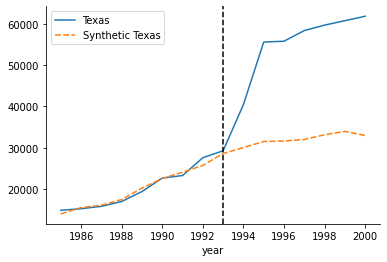

In [210]:
# we use the weights to construct the synthetic Texas
fitted = X @ result.x

dat = y.copy()
dat['Synthetic Texas'] = fitted
dat.index = pd.to_datetime(dat.index, format='%Y')
# Plot both the actual and fitted data
sns.lineplot(dat)
plt.legend(title=None)
plt.axvline(x=pd.to_datetime('1993', format='%Y'), linestyle='--', color='black')
sns.despine()

### 5. Augmented SCM
`Motivation:` 

+ 1. When “the pretreatment fit is poor or the number of pretreatment periods is small,” Abadie, Diamond, and Hainmueller (2015) recommended against using SCM. Augmented SCM enables the use of (a modified) SCM approach in many of the cases where SCM alone is infeasible.

+ 2. Bias correction and doubly robust feature

\begin{align}
\hat{Y}_{1T}^{aug}(0) &= \sum_{W_i=0} \hat{\gamma}_i^{scm} Y_{iT} +  \underbrace{ \left(\hat{m}_{1T} - \sum_{W_i=0} \hat{\gamma}_i^{scm} \hat{m}_{iT}\right) }_{Bias \: correction \:term} \tag{9} \\

&= \hat{m}_{1T} + \underbrace{\sum_{W_i=0} \hat{\gamma}_i^{scm} (Y_{iT} - \hat{m}_{iT})}_{doubly \: robust \: feature} \tag{10}
\end{align}
where the $\hat{\gamma}^{scm}_i$ is the canonical SCM (equation 8) estimated weights. Equation (9) directly corrects the SCM estimate, $\sum \hat{\gamma_i}^{scm}Y_{iT} $, by the imbalance in a particular function of the pretreatment outcomes $\hat{m}(\cdot) $. Intuitively, since $\hat{m} $ estimates the posttreatment outcome, we can view this as an estimate of the bias due to imbalance, analogous to bias correction for inexact matching (Abadie and Imbens 2011).

### 6. Choice of estimator

+ First, consider an estimator that is linear in pretreatment outcomes, $\hat{m}(X) = \hat{\eta}_0 + \boldsymbol{\hat{\eta}} \cdot \boldsymbol{X} $. Then the equation (9) can be written as:

\begin{equation}
\hat{Y}_{1T}^{aug}(0) = \sum_{W_i=0} \hat{\gamma}_i^{scm} Y_{iT} + \sum_{t=1}^{T_0} \hat{\eta}_t \left( X_{1t} - \sum_{W_i=0} \hat{\gamma}_i^{scm} X_{it} \right) \tag{11}
\end{equation}

+ Second, consider an estimator that is a linear combination of comparison unit's posttreatment outcomes, $\hat{m}(X) = \sum_{w_i=0} \hat{\alpha}_i (X)Y_{iT} $, where $\hat{\alpha}$ is a weighting function.

\begin{align}
\hat{Y}_{1T}^{aug}(0) &= \sum_{W_i=0} \left( \hat{\gamma}_i^{scm} + \hat{\gamma}_i^{adj} \right) Y_{iT}, \text{ where} \notag\\

\hat{\gamma}_i^{adj} &\equiv \hat{\alpha}_i(\mathbf{X}_1) - \sum_{W_j=0} \hat{\gamma}_j^{scm} \hat{\alpha}_i(\mathbf{X}_j). \tag{12}
\end{align}


### 7. Ridge ASCM

With Ridge ASCM, the estimator for the post-treatment outcome is $\hat{m}(X_i) = \hat{\eta}_{0}^{ridge} + X'_i\hat{\eta}^{ridge} $

\begin{align}
\left\{ \hat{\eta}_0^{ridge}, \hat{\eta}^{ridge} \right\} = &\underset{\eta_0,\eta}{\text{arg min}} \left[ \frac{1}{2} \sum_{W_i=0} (Y_i - (\eta_0 + X_i'\eta))^2 + \lambda^{ridge} \|\eta\|_2^2 \right] \tag{14} \\
& + \lambda^{ridge} ||\eta||^2_2 \notag
\end{align}

The Ridge Augmented SCM estimator is then (indicated by euqation (11)):
\begin{equation}
\hat{Y}_{1T}^{aug}(0) = \sum_{W_i=0} \hat{\gamma}_i^{scm} Y_{iT} + \left( X_1 - \sum_{W_i=0} \hat{\gamma}_i^{scm} X_i \right) \hat{\eta}^{ridge} \tag{15}
\end{equation}


### 8. Lemma 1

+ The ridge-augmented SCM estimator (11) is: 
\begin{equation}
\hat{Y}_{1T}^{aug}(0) = \sum_{W_i=0} \hat{\gamma}_i^{aug} Y_{iT} \tag{16}
\end{equation}

\begin{equation}
\text{where } \hat{\gamma}_i^{aug} = \hat{\gamma}_i^{scm} + (X_1 - X_0' \hat{\gamma}^{scm})' (X_0' X_0 + \lambda^{ridge} I_{T_0})^{-1} X_{i.}. \tag{17}
\end{equation}



In [211]:
# gamma_scm is the optimal weights from SCM
gamma_scm = result.x

# define ridge penalty term lambda_ridge
lambda_ridge = 0.1

# based on equation 17, we can calculate the optimal weights of augmeted SCM
def AugSCM(X0, X1, lambda_ridge, gamma_scm):

    gamma_aug = gamma_scm + (X1 - X0@gamma_scm).T @ np.linalg.inv(X0@X0.T + lambda_ridge*np.identity(X0.shape[0])) @ X0
    
    return gamma_aug

gamma_aug = AugSCM(X0, X1, lambda_ridge, gamma_scm)


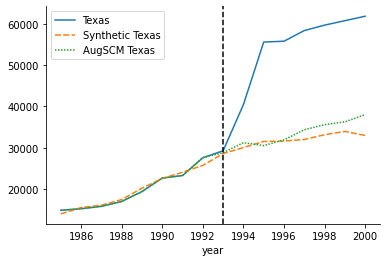

In [212]:
# we use the weights to construct the synthetic Texas
fitted_aug = X @ gamma_aug

dat['AugSCM Texas'] = fitted_aug.values
# Plot both the actual and fitted data
sns.lineplot(dat)
plt.legend(title=None)
plt.axvline(x=pd.to_datetime('1993', format='%Y'), linestyle='--', color='black')
sns.despine()

+ plase note that the pre-treatment fit has been improved 

Let's check if there are extrem weights

In [213]:
print("Mean:", np.mean(gamma_aug))
print("Median:", np.median(gamma_aug))
print("Standard Deviation:", np.std(gamma_aug))
print("Min:", np.min(gamma_aug))
print("Max:", np.max(gamma_aug))

Mean: 0.03905801639467408
Median: 0.004647049313479091
Standard Deviation: 0.34224905000378436
Min: -0.6957951987907506
Max: 1.7106456359634592


+ Comparing to the weights we got from cannonical SCM, whose weights are all non-negative and and less than 1!

In [214]:
print("Mean:", np.mean(gamma_scm))
print("Median:", np.median(gamma_scm))
print("Standard Deviation:", np.std(gamma_scm))
print("Min:", np.min(gamma_scm))
print("Max:", np.max(gamma_scm))

Mean: 0.020000031583080186
Median: 3.4051804928650657e-12
Standard Deviation: 0.07988975272536264
Min: 5.432274230165391e-13
Max: 0.3725138927224733


+ The Ridge ASCM weights $\hat{\gamma}^{aug}$ can also be describled as the solution to:

\begin{equation}
\tag{18}
\min_{\gamma} \quad \frac{1}{2\lambda^{ridge}} \| X_1 - X_0' \gamma \|_2^2 + \frac{1}{2} \| \gamma - \hat{\gamma}^{scm} \|_2^2 \quad \text{s.t.} \quad \sum_i \gamma_i = 1
\end{equation}


In [215]:
# set initiall weights
initial_w = np.ones(X0.shape[1])/X0.shape[1]
# set value for lambda
lambda_r = 5

# define the objevtive function
def obj_fun_aug(gamma, gamma_scm, lambda_r):
    m = np.mean(np.sqrt((X1 - X0@gamma)**2))
    n = np.mean(np.sqrt((gamma - gamma_scm)**2))
    return 1/2/lambda_r*m + 1/2*n

# no bounds
bounds = Bounds(lb=-np.inf, ub=np.inf)

# set constraints, sum to 1
constraints = LinearConstraint(np.ones(X0.shape[1]), lb=1, ub=1)

result_aug = minimize(obj_fun_aug, x0=initial_w, args=(gamma_scm, lambda_r), bounds=bounds, constraints=constraints)

In [216]:
result_aug

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.070219631754861
       x: [ 1.119e-04  1.947e-03 ...  1.216e-01  4.795e-03]
     nit: 67
     jac: [-1.529e+02 -4.865e+00 ... -5.530e+01 -5.525e-01]
    nfev: 3539
    njev: 67

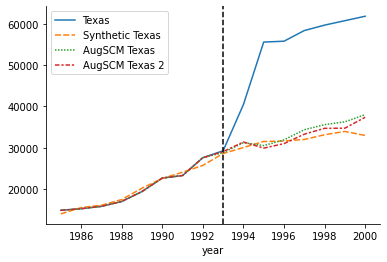

In [217]:
# we use the weights to construct the synthetic Texas
fitted_aug = X @ result_aug.x

dat['AugSCM Texas 2'] = fitted_aug.values
# Plot both the actual and fitted data
sns.lineplot(dat)
plt.legend(title=None)
plt.axvline(x=pd.to_datetime('1993', format='%Y'), linestyle='--', color='black')
sns.despine()

In [218]:
print("Mean:", np.mean(result_aug.x))
print("Median:", np.median(result_aug.x))
print("Standard Deviation:", np.std(result_aug.x))
print("Min:", np.min(result_aug.x))
print("Max:", np.max(result_aug.x))

Mean: 0.02
Median: 0.0019516270716886785
Standard Deviation: 0.3722197120042634
Min: -0.7788328184005299
Max: 2.1605718592223004


### 9. Lemma 2

We can similarly characterize ridge regression alone as a solution to a penalized SCM problem as describle by equation (8) where the penalty term, is $f(\gamma_i) = \left( \gamma_i - \frac{1}{N_0} \right)^2$, penalizes the variance of the weights. Other penalized linear models, such as the LASSO or elastic net, do not have this same representation as a penalized SCM estimator.

\begin{equation}
\min_{\gamma} \frac{1}{2\lambda^{ridge}} \| X_1 - X_0 \gamma \|_2^2 + \frac{1}{2} \left\| \gamma - \frac{1}{N_0} \right\|_2^2 \tag{19} \quad s.t \sum_i \gamma_i=1 
\end{equation}


In [219]:
# set initiall weights
initial_w = np.ones(X0.shape[1])/X0.shape[1]
# set value for lambda
lambda_r = 20

# define a new abjective function
def obj_fun_aug3(gamma, lambda_r):
    m = np.mean(np.sqrt((X1 - X0@gamma)**2))
    n = np.mean(np.sqrt((gamma - np.ones(X0.shape[1])/X0.shape[1])**2))
    return 0.5/lambda_r*m + 0.5*n

# no bounds
bounds = Bounds(lb=-np.inf, ub=np.inf)

# set constraints, sum to 1
constraints = LinearConstraint(np.ones(X0.shape[1]), lb=1, ub=1)

result_aug3 = minimize(obj_fun_aug3, initial_w, args=(lambda_r), bounds=bounds, constraints=constraints)

In [220]:
result_aug3

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.06756529482014346
       x: [ 2.155e-02  1.277e-02 ...  9.018e-03  2.132e-02]
     nit: 53
     jac: [ 1.179e+02  3.653e+00 ...  3.754e+01  5.569e-01]
    nfev: 2815
    njev: 53

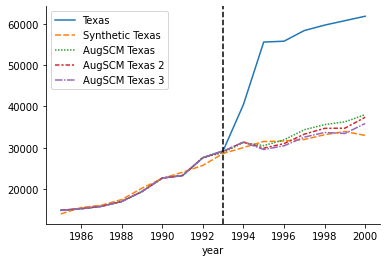

In [221]:
# we use the weights to construct the synthetic Texas
fitted_aug = X @ result_aug3.x

dat['AugSCM Texas 3'] = fitted_aug.values
# Plot both the actual and fitted data
sns.lineplot(dat)
plt.legend(title=None)
plt.axvline(x=pd.to_datetime('1993', format='%Y'), linestyle='--', color='black')
sns.despine()

In [222]:
print("Mean:", np.mean(result_aug3.x))
print("Median:", np.median(result_aug3.x))
print("Standard Deviation:", np.std(result_aug3.x))
print("Min:", np.min(result_aug3.x))
print("Max:", np.max(result_aug3.x))

Mean: 0.019999999999999997
Median: 0.020174947357786195
Standard Deviation: 0.37464310691392916
Min: -0.7549968896927712
Max: 2.177908258605102


### 10. Lemma 3
Let $\frac{1}{N_0}X_0 = UDV' $ be the singular value decomposition of the matrix of control pre-intervention outcomes.

\begin{align}
\| X_1 - X_0' \hat{\gamma}^{aug} \|_2 &= \lambda \| (D + \lambda I)^{-1} (\tilde{X}_1 - \tilde{X}_0 \hat{\gamma}^{scm}) \|_2 \notag\\

&\leq \frac{\lambda}{d_m^2 + \lambda} \| X_1 - X_0 \hat{\gamma}^{scm} \|_2, \tag{20}
\end{align}

\begin{align}
\| X_1 - X_0' \hat{\gamma}^{ridge} \|_2 &= \lambda \| (D + \lambda I)^{-1} \tilde{X}_1 \|_2 \notag \\

&\leq \frac{\lambda}{d_m^2 + \lambda} \| \tilde{X}_1 \|_2, \tag{21}
\end{align}

$\tilde{X_i}=V'X_i $ is the rotation of $X_i$ along the sigular vectors of $X_0$.

+ Notice: Ridge ASCM Improves Pretreatment Fit Relative to SCM Alone

In [200]:
# version 1
# singular value decomposition
S, V, D = np.linalg.svd(X0/np.sqrt(X0.shape[1]), full_matrices=False)

# rotate X_i
X0_tilde, X1_tilde = S.T@X0, S.T@X1

res = {}
for lambda_r in np.linspace(0.1, 1e+3, 1000):
    inv = np.linalg.inv(np.diag(V)+ lambda_r*np.diag(np.ones(len(V))))

    dis_ascm = lambda_r*np.linalg.norm(inv@(X1_tilde - X0_tilde@gamma_scm))
    dis_ridge = lambda_r*np.linalg.norm(inv@X1_tilde)
    res[lambda_r] = dis_ascm, dis_ridge

In [201]:
pd.DataFrame.from_dict(res, orient='index')

,0,1
0.100000,1.627006,1.705742
1.100901,17.752697,18.619395
2.101802,33.594913,35.249378
3.102703,49.161530,51.603587
4.103604,64.460128,67.689623
...,...,...
995.996396,1910.873166,3160.042199
996.997297,1911.216440,3161.933763
997.998198,1911.559238,3163.825162
998.999099,1911.901561,3165.716396


In [271]:
# version 2
# singular value decomposition
S, V, D = np.linalg.svd(X0/np.sqrt(X0.shape[1]), full_matrices=False)
# construct V_
V_ = np.concatenate((V, np.zeros(X0.shape[1] - len(V))))

# rotate X_i
X0_tilde, X1_tilde = D.T@X0, D.T@X1

res = {}
for lambda_r in np.linspace(0.1, 1e+3, 1000):
    inv = np.linalg.inv(np.diag(V_)+ lambda_r*np.diag(np.ones(len(V_))))

    dis_ascm = lambda_r*np.linalg.norm(inv@(X1_tilde - X0_tilde@gamma_scm))
    dis_ridge = lambda_r*np.linalg.norm(inv@X1_tilde)
    res[lambda_r] = dis_ascm, dis_ridge

In [272]:
pd.DataFrame.from_dict(res, orient='index')


,0,1
0.100000,2400.285650,52805.472413
1.100901,2400.288502,52805.573430
2.101802,2400.295936,52805.838425
3.102703,2400.307725,52806.261533
4.103604,2400.323652,52806.837099
...,...,...
995.996396,2431.128879,54540.696951
996.997297,2431.136498,54541.211938
997.998198,2431.144105,54541.726140
998.999099,2431.151700,54542.239560


In [13]:
df = pd.read_csv("data/basque.csv")
dataprep = Dataprep(
    foo=df,
    predictors=[
        "school.illit",
        "school.prim",
        "school.med",
        "school.high",
        "school.post.high",
        "invest",
    ],
    predictors_op="mean",
    time_predictors_prior=range(1964, 1970),
    special_predictors=[
        ("gdpcap", range(1960, 1970), "mean"),
        ("sec.agriculture", range(1961, 1970, 2), "mean"),
        ("sec.energy", range(1961, 1970, 2), "mean"),
        ("sec.industry", range(1961, 1970, 2), "mean"),
        ("sec.construction", range(1961, 1970, 2), "mean"),
        ("sec.services.venta", range(1961, 1970, 2), "mean"),
        ("sec.services.nonventa", range(1961, 1970, 2), "mean"),
        ("popdens", [1969], "mean"),
    ],
    dependent="gdpcap",
    unit_variable="regionname",
    time_variable="year",
    treatment_identifier="Basque Country (Pais Vasco)",
    controls_identifier=[
        "Andalucia",
        "Aragon",
        "Baleares (Islas)",
        "Canarias",
        "Cantabria",
        "Castilla-La Mancha",
        "Castilla Y Leon",
        "Cataluna",
        "Comunidad Valenciana",
        "Extremadura",
        "Galicia",
        "Madrid (Comunidad De)",
        "Murcia (Region de)",
        "Navarra (Comunidad Foral De)",
        "Principado De Asturias",
        "Rioja (La)",
        "Spain (Espana)",
    ],
    time_optimize_ssr=range(1960, 1970),
)

augsynth = AugSynth()
augsynth.fit(dataprep=dataprep)

In [14]:
print(dataprep)

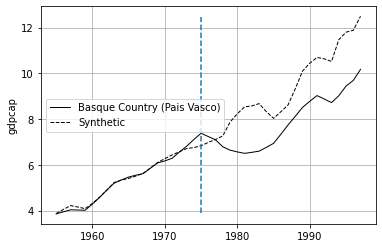

In [17]:
augsynth.path_plot(time_period=range(1955, 1998), treatment_time=1975)

In [33]:
df = pd.read_stata("data/texas.dta")
dataprep = Dataprep(
    foo=df,
    predictors=["income", "ur", "poverty"],
    predictors_op="mean",
    time_predictors_prior=range(1985, 1994),
    special_predictors=[
        ("bmprison", [1988], "mean"),
        ("bmprison", [1990], "mean"),
        ("bmprison", [1991], "mean"),
        ("bmprison", [1992], "mean"),
        ("alcohol", [1990], "mean"),
        ("aidscapita", [1990], "mean"),
        ("aidscapita", [1991], "mean"),
        ("black", [1990], "mean"),
        ("black", [1991], "mean"),
        ("black", [1992], "mean"),
        ("perc1519", [1990], "mean"),
    ],
    dependent="bmprison",
    unit_variable="state",
    time_variable="year",
    treatment_identifier="Texas",
    controls_identifier=[
        "Alabama",
        "Alaska",
        "Arizona",
        "Arkansas",
        "California",
        "Colorado",
        "Connecticut",
        "Delaware",
        "District of Columbia",
        "Florida",
        "Georgia",
        "Hawaii",
        "Idaho",
        "Illinois",
        "Indiana",
        "Iowa",
        "Kansas",
        "Kentucky",
        "Louisiana",
        "Maine",
        "Maryland",
        "Massachusetts",
        "Michigan",
        "Minnesota",
        "Mississippi",
        "Missouri",
        "Montana",
        "Nebraska",
        "Nevada",
        "New Hampshire",
        "New Jersey",
        "New Mexico",
        "New York",
        "North Carolina",
        "North Dakota",
        "Ohio",
        "Oklahoma",
        "Oregon",
        "Pennsylvania",
        "Rhode Island",
        "South Carolina",
        "South Dakota",
        "Tennessee",
        "Utah",
        "Vermont",
        "Virginia",
        "Washington",
        "West Virginia",
        "Wisconsin",
        "Wyoming",
    ],
    time_optimize_ssr=range(1985, 1994),
)

print(dataprep)


In [34]:
synth = Synth()
synth.fit(dataprep=dataprep, optim_method="BFGS", optim_initial="ols")

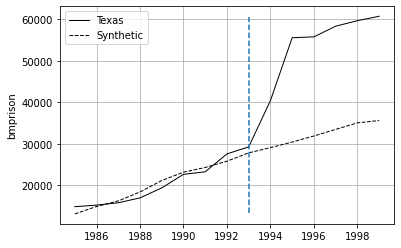

In [35]:
synth.path_plot(time_period=range(1985, 2000), treatment_time=1993)

In [38]:
augsynth = AugSynth()
augsynth.fit(dataprep=dataprep)

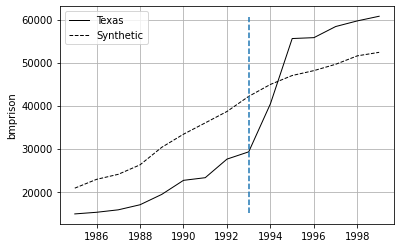

In [39]:
augsynth.path_plot(time_period=range(1985, 2000), treatment_time=1993)

In [298]:
A = np.random.randint(1, 7, (2, 3))
A

array([[1, 3, 5],
       [3, 5, 1]])

In [299]:
SL = A@A.T

In [300]:
np.linalg.eig(SL)

EigResult(eigenvalues=array([58., 12.]), eigenvectors=array([[ 0.70710678, -0.70710678],
       [ 0.70710678,  0.70710678]]))

In [301]:
np.linalg.eig(A.T@A)

EigResult(eigenvalues=array([5.8000000e+01, 5.8753181e-16, 1.2000000e+01]), eigenvectors=array([[-0.37139068, -0.83390785, -0.40824829],
       [-0.74278135,  0.53066863, -0.40824829],
       [-0.55708601, -0.15161961,  0.81649658]]))

In [306]:
S, V, D = np.linalg.svd(A, full_matrices=False)

In [307]:
S

array([[-0.70710678, -0.70710678],
       [-0.70710678,  0.70710678]])

In [308]:
V

array([7.61577311, 3.46410162])

In [309]:
D

array([[-0.37139068, -0.74278135, -0.55708601],
       [ 0.40824829,  0.40824829, -0.81649658]])

In [312]:
D@D.T

array([[1.00000000e+00, 1.94672571e-16],
       [1.94672571e-16, 1.00000000e+00]])